In [1]:
import pandas as pd
import sys
sys.path.append('../..')
import sentinel



In [2]:
!pwd

/Users/jomaver/Library/CloudStorage/OneDrive-GrupoBancolombia/AIL/AIOPs/SLA-Analisis-logs-python/sla/docs/notebooks


In [3]:
import os

# Leer todos los archivos CSV en la carpeta ./data/PDTI/
csv_files = [os.path.join('../../../../WAS/feb-11/', file) for file in os.listdir('../../../../WAS/feb-11/') if file.endswith('.csv')]

# Concatenar todos los archivos CSV en un solo dataframe
structured_logs = pd.concat((pd.read_csv(file) for file in csv_files), ignore_index=True)#.head(1000)

structured_logs.head()

,ingestion_year,ingestion_month,ingestion_day,hrarcb,idnmsg,tipomsg,mes,dia,hrarsp,sistema,...,fncorg,ofcorg,secofc,fncres,codtrn,clvtrn,datos,year,month,day
0,2025,2,12,19470041,,220,2,11,0,SVP,...,SVP,276,1,0,3600,19470041712209326153,0000000000038212128000000000000000000000000000...,2025,2,12
1,2025,2,12,19470041,,220,2,11,0,SVP,...,SVP,276,1,0,369,19470041712209457555,0000000000052183534000000000000000000000000000...,2025,2,12
2,2025,2,12,19470042,,230,2,11,19470042,SVP,...,SVP,276,2,0,369,19470041712209266622,0000000000043807888000000000000000000000000000...,2025,2,12
3,2025,2,12,19470042,,220,2,11,0,SVP,...,SVP,276,1,0,3600,19470042712209266632,0000000001046932694000000000000000000000000000...,2025,2,12
4,2025,2,12,19470042,,230,2,11,19470042,APP,...,APP,276,2,0,345,19470038712209326073,0000000001128419041000000000000000000000000000...,2025,2,12


In [4]:
#structured_logs[['hrarcb', 'hrarsp', 'hrainicn', 'hrainirs', 'hrafinrs', 'hrafincn', 'dtqhra']].tail()

In [5]:
def convert_to_time(value):
    try:
        value_str = str(value).zfill(8)  # Asegurarse de que el valor tenga 8 dígitos
        if len(value_str) == 7:
            hours = int(value_str[0])
            minutes = int(value_str[1:3])
            seconds = int(value_str[3:5])
        else:
            hours = int(value_str[:2])
            minutes = int(value_str[2:4])
            seconds = int(value_str[4:6])
        return f"{hours:02}:{minutes:02}:{seconds:02}"
    except: 
        return value

columns_to_convert = ['hrarcb', 'hrarsp']

structured_logs['hora'] = structured_logs['hrarcb'].apply(convert_to_time)
structured_logs['hrarsp'] = structured_logs['hrarsp'].apply(convert_to_time)

structured_logs[['hrarcb','hora', 'hrarsp']].head()

,hrarcb,hora,hrarsp
0,19470041,19:47:00,00:00:00
1,19470041,19:47:00,00:00:00
2,19470042,19:47:00,19:47:00
3,19470042,19:47:00,00:00:00
4,19470042,19:47:00,19:47:00


In [6]:
peticiones = structured_logs[structured_logs['tipomsg'] == 220]
respuestas = structured_logs[structured_logs['tipomsg'] == 230]

joined_logs = peticiones.drop(columns=['hrarsp','fncres']).merge(respuestas[['clvtrn', 'hrarsp','fncres']], on='clvtrn', how='left')

In [7]:
print(len(peticiones), len(respuestas),len(joined_logs))

9387226 9382594 9387356


In [8]:
joined_logs.columns

Index(['ingestion_year', 'ingestion_month', 'ingestion_day', 'hrarcb',
       'idnmsg', 'tipomsg', 'mes', 'dia', 'sistema', 'tpooper', 'timeout',
       'nrodtq', 'fecha', 'hrainicn', 'hrainirs', 'hrafinrs', 'hrafincn',
       'nrosec', 'indest', 'indlog', 'indpba', 'eqporg', 'eqpdst', 'lngdta',
       'espacio', 'dtqdia', 'dtqhra', 'fncdem', 'fnctpo', 'fncmsg', 'fnccdg',
       'diseno', 'fncorg', 'ofcorg', 'secofc', 'codtrn', 'clvtrn', 'datos',
       'year', 'month', 'day', 'hora', 'hrarsp', 'fncres'],
      dtype='object')

In [9]:
# Convertir las columnas 'hora' y 'hrarsp' a formato datetime
joined_logs['hora'] = pd.to_datetime(joined_logs['hora'], format='%H:%M:%S')
joined_logs['hrarsp'] = pd.to_datetime(joined_logs['hrarsp'], format='%H:%M:%S')

# Calcular la diferencia en segundos
joined_logs['time_diff_seconds'] = (joined_logs['hrarsp'] - joined_logs['hora']).dt.total_seconds()

joined_logs[['hora', 'hrarsp', 'time_diff_seconds']].head()

,hora,hrarsp,time_diff_seconds
0,1900-01-01 19:47:00,1900-01-01 19:47:00,0.0
1,1900-01-01 19:47:00,1900-01-01 19:47:00,0.0
2,1900-01-01 19:47:00,1900-01-01 19:47:00,0.0
3,1900-01-01 19:47:00,1900-01-01 19:47:00,0.0
4,1900-01-01 19:47:00,1900-01-01 19:47:00,0.0


/Users/jomaver/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


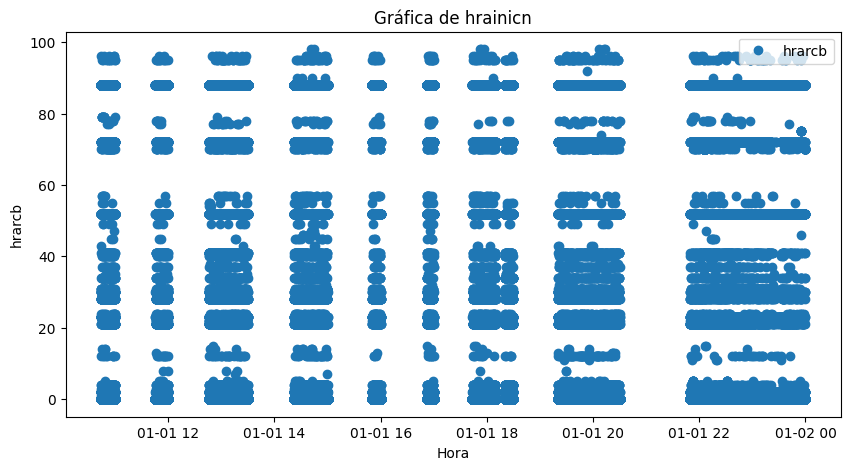

In [10]:
import matplotlib.pyplot as plt

# Convertir la columna 'hrarcb' a datetime y establecerla como índice
structured_logs['hora'] = pd.to_datetime(structured_logs['hora'], format='%H:%M:%S')
#structured_logs.set_index('hrarcb', inplace=True)
#structured_logs.sort_index(inplace=True)
plt.figure(figsize=(10, 5))
plt.plot(joined_logs['hora'], joined_logs['fncres'], 'o',label='hrarcb')
plt.xlabel('Hora')
plt.ylabel('hrarcb')
plt.title('Gráfica de hrainicn')
plt.legend()
plt.show()



In [11]:
from sklearn.feature_selection import VarianceThreshold

# Determinar columnas con muchos valores nulos
null_threshold = 0.5  # Umbral del 50%
columns_with_many_nulls = joined_logs.columns[joined_logs.isnull().mean() > null_threshold]

# Codificación de frecuencia para columnas de tipo string
string_columns = joined_logs.select_dtypes(include=['object']).columns
for column in string_columns:
    freq_encoding = joined_logs[column].value_counts().to_dict()
    joined_logs[column + '_freq'] = joined_logs[column].map(freq_encoding)

# Seleccionar solo las columnas numéricas para calcular la varianza
numeric_columns = joined_logs.select_dtypes(include=['number']).columns
selector = VarianceThreshold(threshold=0.01)  # Umbral de varianza
selector.fit(joined_logs[numeric_columns])
low_variance_columns = numeric_columns[~selector.get_support()]



In [12]:
print("Columnas con muchos valores nulos:", columns_with_many_nulls)
#low_variance_columns = low_variance_columns.drop('fncres_freq')
print("Columnas con casi nula varianza:", low_variance_columns)

Columnas con muchos valores nulos: Index([], dtype='object')
Columnas con casi nula varianza: Index(['ingestion_year_freq', 'ingestion_month_freq', 'ingestion_day_freq',
       'idnmsg_freq', 'tipomsg_freq', 'mes_freq', 'dia_freq', 'tpooper_freq',
       'timeout_freq', 'fecha_freq', 'hrainirs_freq', 'hrafinrs_freq',
       'hrafincn_freq', 'indest_freq', 'indlog_freq', 'indpba_freq',
       'eqporg_freq', 'eqpdst_freq', 'lngdta_freq', 'espacio_freq',
       'dtqdia_freq', 'fncdem_freq', 'fnctpo_freq', 'fncmsg_freq',
       'fnccdg_freq', 'diseno_freq', 'ofcorg_freq', 'secofc_freq',
       'clvtrn_freq', 'datos_freq', 'year_freq', 'month_freq', 'day_freq'],
      dtype='object')


In [13]:
low_variance_columns_names = []
for list_ in low_variance_columns:
    low_variance_columns_names += [list_.replace('_freq','')]

In [14]:
joined_logs[low_variance_columns_names]

,ingestion_year,ingestion_month,ingestion_day,idnmsg,tipomsg,mes,dia,tpooper,timeout,fecha,...,fncmsg,fnccdg,diseno,ofcorg,secofc,clvtrn,datos,year,month,day
0,2025,2,12,,220,2,11,1,0,211,...,O,0,,276,1,19470041712209326153,0000000000038212128000000000000000000000000000...,2025,2,12
1,2025,2,12,,220,2,11,1,0,211,...,O,0,,276,1,19470041712209457555,0000000000052183534000000000000000000000000000...,2025,2,12
2,2025,2,12,,220,2,11,1,0,211,...,O,0,,276,1,19470042712209266632,0000000001046932694000000000000000000000000000...,2025,2,12
3,2025,2,12,,220,2,11,1,0,211,...,O,0,,276,1,19470042712209326163,0000000001214721769000000000000000000000000000...,2025,2,12
4,2025,2,12,,220,2,11,1,0,211,...,O,0,,276,1,19470042712209872171,0000000000024989837000000000000000000000000000...,2025,2,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9387351,2025,2,12,,220,2,11,1,0,211,...,O,0,,276,1,15592621575660219561,0000000000098657564000000000000000000000000000...,2025,2,12
9387352,2025,2,12,,220,2,11,1,0,211,...,O,0,,276,1,15592621575669948164,0000000000019396807000008824606223970000003152...,2025,2,12
9387353,2025,2,12,,220,2,11,1,0,211,...,O,0,,276,1,15592621575669757872,0000000001037072269000000000000000000000000000...,2025,2,12
9387354,2025,2,12,,220,2,11,1,0,211,...,O,0,,276,1,15592621575669757882,0000000000098646780000000000000000000000000000...,2025,2,12


In [15]:
joined_logs.columns

Index(['ingestion_year', 'ingestion_month', 'ingestion_day', 'hrarcb',
       'idnmsg', 'tipomsg', 'mes', 'dia', 'sistema', 'tpooper', 'timeout',
       'nrodtq', 'fecha', 'hrainicn', 'hrainirs', 'hrafinrs', 'hrafincn',
       'nrosec', 'indest', 'indlog', 'indpba', 'eqporg', 'eqpdst', 'lngdta',
       'espacio', 'dtqdia', 'dtqhra', 'fncdem', 'fnctpo', 'fncmsg', 'fnccdg',
       'diseno', 'fncorg', 'ofcorg', 'secofc', 'codtrn', 'clvtrn', 'datos',
       'year', 'month', 'day', 'hora', 'hrarsp', 'fncres', 'time_diff_seconds',
       'ingestion_year_freq', 'ingestion_month_freq', 'ingestion_day_freq',
       'hrarcb_freq', 'idnmsg_freq', 'tipomsg_freq', 'mes_freq', 'dia_freq',
       'sistema_freq', 'tpooper_freq', 'timeout_freq', 'nrodtq_freq',
       'fecha_freq', 'hrainicn_freq', 'hrainirs_freq', 'hrafinrs_freq',
       'hrafincn_freq', 'nrosec_freq', 'indest_freq', 'indlog_freq',
       'indpba_freq', 'eqporg_freq', 'eqpdst_freq', 'lngdta_freq',
       'espacio_freq', 'dtqdia_freq', 

In [16]:
# Extraer horas, minutos y segundos de la columna 'hora'
joined_logs['hour'] = joined_logs['hora'].dt.hour
joined_logs['minute'] = joined_logs['hora'].dt.minute
joined_logs['second'] = joined_logs['hora'].dt.second

# Crear la columna 'timestamp' con año, mes, día, hora, minuto y segundo
joined_logs['timestamp'] = pd.to_datetime(joined_logs[['ingestion_year', 'mes', 'dia', 'hour', 'minute', 'second']].rename(columns={'mes': 'month', 'dia': 'day', 'ingestion_year': 'year'}))

joined_logs[['timestamp', 'hora']].head()


,timestamp,hora
0,2025-02-11 19:47:00,1900-01-01 19:47:00
1,2025-02-11 19:47:00,1900-01-01 19:47:00
2,2025-02-11 19:47:00,1900-01-01 19:47:00
3,2025-02-11 19:47:00,1900-01-01 19:47:00
4,2025-02-11 19:47:00,1900-01-01 19:47:00


In [17]:
# Drop columns with low variance, low variance column names, and 'hora'
columns_to_drop = low_variance_columns_names + ['hora']
filtered_logs = joined_logs.drop(columns=columns_to_drop)
filtered_logs = filtered_logs.drop(columns=low_variance_columns)
filtered_logs = filtered_logs.drop(columns=['hrarcb', 'hrarsp',
       'hrainicn',  'dtqhra', 
       'sistema_freq',  'nrodtq_freq', 'hrainicn_freq',
        'nrosec_freq', 'dtqhra_freq', 'fncorg_freq', 'codtrn_freq', 'hour', 'minute', 'second', 'nrosec','hrarcb_freq','fncres_freq'])

filtered_logs.head()

,sistema,nrodtq,fncorg,codtrn,fncres,time_diff_seconds,timestamp
0,SVP,APP,SVP,3600,0,0.0,2025-02-11 19:47:00
1,SVP,APP,SVP,369,0,0.0,2025-02-11 19:47:00
2,SVP,APP,SVP,3600,88,0.0,2025-02-11 19:47:00
3,APP,APP,APP,1464,0,0.0,2025-02-11 19:47:00
4,SVP,APP,SVP,369,0,0.0,2025-02-11 19:47:00


In [18]:
filtered_logs.columns

Index(['sistema', 'nrodtq', 'fncorg', 'codtrn', 'fncres', 'time_diff_seconds',
       'timestamp'],
      dtype='object')

In [19]:
# Crear la columna 'respuesta_exitosa'
filtered_logs['respuesta_exitosa'] = (filtered_logs['fncres'] == 0).astype(int)

filtered_logs['respuesta_no_exitosa'] = (filtered_logs['fncres'] != 0).astype(int)

filtered_logs['sin_respuesta'] = (filtered_logs['fncres'].isna()).astype(int)

filtered_logs.head(50)

,sistema,nrodtq,fncorg,codtrn,fncres,time_diff_seconds,timestamp,respuesta_exitosa,respuesta_no_exitosa,sin_respuesta
0,SVP,APP,SVP,3600,0,0.0,2025-02-11 19:47:00,1,0,0
1,SVP,APP,SVP,369,0,0.0,2025-02-11 19:47:00,1,0,0
2,SVP,APP,SVP,3600,88,0.0,2025-02-11 19:47:00,0,1,0
3,APP,APP,APP,1464,0,0.0,2025-02-11 19:47:00,1,0,0
4,SVP,APP,SVP,369,0,0.0,2025-02-11 19:47:00,1,0,0
5,APP,APP,APP,1460,0,0.0,2025-02-11 19:47:00,1,0,0
6,APP,APP,APP,1464,0,0.0,2025-02-11 19:47:00,1,0,0
7,SVP,APP,SVP,538,0,0.0,2025-02-11 19:47:00,1,0,0
8,APP,APP,APP,1460,0,0.0,2025-02-11 19:47:00,1,0,0
9,SVP,APP,SVP,3600,88,0.0,2025-02-11 19:47:00,0,1,0



    - tipomsg 220 corresponde a tpooper 1 y topomsg 230 = tpooper 2
    - 220 = Petición  
    - 230 = respuesta

In [20]:
filtered_logs_APP = filtered_logs[filtered_logs['nrodtq'] == 'APP']
filtered_logs_APP['time_diff_seconds'].fillna(-100, inplace=True)


/var/folders/ck/pscdwm851rb3zr3vrmnv_hwm0000gr/T/ipykernel_87840/4172820518.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  filtered_logs_APP['time_diff_seconds'].fillna(-100, inplace=True)
/var/folders/ck/pscdwm851rb3zr3vrmnv_hwm0000gr/T/ipykernel_87840/4172820518.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_logs_APP['time

In [21]:
filtered_logs['fncres'].value_counts()

fncres
0     8980271
88     301867
52      25454
2       10631
72       7916
23       7191
21       4279
30       2866
28       2614
4        1476
41       1245
31       1104
34        924
70        775
37        449
40        364
22        339
24        253
95        219
12        200
1         147
57        105
78         93
55         83
96         73
3          73
5          51
35         44
49         41
77         35
45         30
32         28
38         25
14         24
39         20
79         17
13         15
43         11
75         10
46          9
98          8
90          7
8           7
11          6
15          6
47          5
54          4
36          3
7           2
92          1
74          1
Name: count, dtype: int64

In [22]:
filtered_logs_APP.info()

filtered_logs_APP.fillna(-100, inplace=True)
filtered_logs_APP['fncres'] = filtered_logs_APP['fncres'].astype(int)

<class 'pandas.core.frame.DataFrame'>
Index: 8699284 entries, 0 to 9387355
Data columns (total 10 columns):
 #   Column                Dtype         
---  ------                -----         
 0   sistema               object        
 1   nrodtq                object        
 2   fncorg                object        
 3   codtrn                object        
 4   fncres                object        
 5   time_diff_seconds     float64       
 6   timestamp             datetime64[ns]
 7   respuesta_exitosa     int64         
 8   respuesta_no_exitosa  int64         
 9   sin_respuesta         int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 730.1+ MB


/var/folders/ck/pscdwm851rb3zr3vrmnv_hwm0000gr/T/ipykernel_87840/28367173.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  filtered_logs_APP.fillna(-100, inplace=True)
/var/folders/ck/pscdwm851rb3zr3vrmnv_hwm0000gr/T/ipykernel_87840/28367173.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_logs_APP.fillna(-100, inplace=True)
/var/folders/ck/pscdwm851rb3zr3vrmnv_hwm0000gr/T/ipykernel_87840/28367173.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

### Agregación de datos String

In [23]:
# Crear una función personalizada para calcular la moda diferente de 0
def mode_different_from_zero(series):
    filtered_values = series[series != 0]
    return filtered_values.mode().iloc[0] if not filtered_values.mode().empty else 0

# Realizar la agregación cada 30 segundos
aggregated_logs_mode = filtered_logs_APP.resample('30S', on='timestamp').agg({
    'fncres': mode_different_from_zero
})

# Renombrar la columna resultante
aggregated_logs_mode.rename(columns={'fncres': 'mode_different_from_zero'}, inplace=True)

aggregated_logs_mode.head()

/var/folders/ck/pscdwm851rb3zr3vrmnv_hwm0000gr/T/ipykernel_87840/209260370.py:7: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  aggregated_logs_mode = filtered_logs_APP.resample('30S', on='timestamp').agg({


,mode_different_from_zero
timestamp,
2025-02-11 10:43:30,88
2025-02-11 10:44:00,88
2025-02-11 10:44:30,88
2025-02-11 10:45:00,88
2025-02-11 10:45:30,88


In [24]:
aggregated_logs_mode.value_counts()

mode_different_from_zero
 0                          855
 88                         731
 52                           6
-100                          1
Name: count, dtype: int64

In [25]:
import sentinel.transformer
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Crear instancia del agregador
aggregator = sentinel.transformer.StringAggregator(filtered_logs_APP, timestamp_column='timestamp')
    
# Definir métricas personalizadas
column_metrics = {
'sistema': ['count'],
'time_diff_seconds':[np.mean, np.sum, np.min, np.max],
'fncres':[np.sum,'mode','nunique', np.mean],
'codtrn':['mode','nunique'],
'respuesta_exitosa':[np.sum],
'respuesta_no_exitosa':[np.sum],
'sin_respuesta':[np.sum],
    }
    
aggregate_logs = aggregator.create_time_aggregation(
        time_window='30s', 
        column_metrics=column_metrics,
    )

aggregate_logs.rename(columns={'sistema_count':'total_events'},inplace=True)
aggregate_logs.columns

Index(['total_events', 'time_diff_seconds_<function mean at 0x10ba6eee0>',
       'time_diff_seconds_<function sum at 0x10ba69f70>',
       'time_diff_seconds_<function min at 0x10ba6e700>',
       'time_diff_seconds_<function max at 0x10ba6e5e0>',
       'fncres_<function sum at 0x10ba69f70>', 'fncres_mode', 'fncres_nunique',
       'fncres_<function mean at 0x10ba6eee0>', 'codtrn_mode',
       'codtrn_nunique', 'respuesta_exitosa_<function sum at 0x10ba69f70>',
       'respuesta_no_exitosa_<function sum at 0x10ba69f70>',
       'sin_respuesta_<function sum at 0x10ba69f70>',
       'avg_time_between_events_seconds', 'min_time_between_events_seconds',
       'max_time_between_events_seconds'],
      dtype='object')

In [26]:
aggregate_logs.columns = ['total_events', 'time_diff_seconds_mean',
       'time_diff_seconds_sum',
       'time_diff_seconds_min',
       'time_diff_seconds_max',
       'fncres_sum', 'fncres_mode', 'fncres_nunique',
       'fncres_mean', 'codtrn_mode',
       'codtrn_nunique', 'num_respuestas_exitosas',
       'num_respuestas_no_exitosas','num_sin_respuesta','avg_time_between_events_seconds',
       'min_time_between_events_seconds', 'max_time_between_events_seconds',
       ]

aggregate_logs['fncres_mode'] = aggregated_logs_mode['mode_different_from_zero']
aggregate_logs.head()

,total_events,time_diff_seconds_mean,time_diff_seconds_sum,time_diff_seconds_min,time_diff_seconds_max,fncres_sum,fncres_mode,fncres_nunique,fncres_mean,codtrn_mode,codtrn_nunique,num_respuestas_exitosas,num_respuestas_no_exitosas,num_sin_respuesta,avg_time_between_events_seconds,min_time_between_events_seconds,max_time_between_events_seconds
2025-02-11 10:43:30,3375,0.093037,314.0,0.0,3.0,9864,88,9,2.922667,369.0,49,3254,121,0,0.001778,0.0,1.0
2025-02-11 10:44:00,16391,0.099445,1630.0,0.0,5.0,54935,88,17,3.351534,369.0,68,15705,686,0,0.001769,0.0,1.0
2025-02-11 10:44:30,16111,0.091739,1478.0,0.0,3.0,44522,88,17,2.763454,369.0,66,15546,565,0,0.001800,0.0,1.0
2025-02-11 10:45:00,16683,0.095187,1588.0,0.0,5.0,52449,88,17,3.143859,369.0,66,16029,654,0,0.001738,0.0,1.0
2025-02-11 10:45:30,16608,0.097303,1616.0,0.0,5.0,49070,88,17,2.954600,369.0,69,15986,622,0,0.001746,0.0,1.0


In [27]:
aggregate_logs['tasa_exito']= aggregate_logs['num_respuestas_exitosas']/aggregate_logs['total_events']
aggregate_logs['tasa_falla']= aggregate_logs['num_respuestas_no_exitosas']/aggregate_logs['total_events']
aggregate_logs['tasa_sin_respuesta']= aggregate_logs['num_sin_respuesta']/aggregate_logs['total_events']

In [28]:
aggregate_logs.dropna(inplace=True)
aggregate_logs.head(50)


,total_events,time_diff_seconds_mean,time_diff_seconds_sum,time_diff_seconds_min,time_diff_seconds_max,fncres_sum,fncres_mode,fncres_nunique,fncres_mean,codtrn_mode,codtrn_nunique,num_respuestas_exitosas,num_respuestas_no_exitosas,num_sin_respuesta,avg_time_between_events_seconds,min_time_between_events_seconds,max_time_between_events_seconds,tasa_exito,tasa_falla,tasa_sin_respuesta
2025-02-11 10:43:30,3375,0.093037,314.0,0.0,3.0,9864,88,9,2.922667,369.0,49,3254,121,0,0.001778,0.0,1.0,0.964148,0.035852,0.000000
2025-02-11 10:44:00,16391,0.099445,1630.0,0.0,5.0,54935,88,17,3.351534,369.0,68,15705,686,0,0.001769,0.0,1.0,0.958148,0.041852,0.000000
2025-02-11 10:44:30,16111,0.091739,1478.0,0.0,3.0,44522,88,17,2.763454,369.0,66,15546,565,0,0.001800,0.0,1.0,0.964931,0.035069,0.000000
2025-02-11 10:45:00,16683,0.095187,1588.0,0.0,5.0,52449,88,17,3.143859,369.0,66,16029,654,0,0.001738,0.0,1.0,0.960798,0.039202,0.000000
2025-02-11 10:45:30,16608,0.097303,1616.0,0.0,5.0,49070,88,17,2.954600,369.0,69,15986,622,0,0.001746,0.0,1.0,0.962548,0.037452,0.000000
2025-02-11 10:46:00,16637,0.099417,1654.0,0.0,3.0,47963,88,14,2.882912,369.0,64,16019,618,0,0.001743,0.0,1.0,0.962854,0.037146,0.000000
2025-02-11 10:46:30,16410,0.096709,1587.0,0.0,5.0,45156,88,17,2.751737,369.0,68,15841,569,0,0.001767,0.0,1.0,0.965326,0.034674,0.000000
2025-02-11 10:47:00,16974,0.096442,1637.0,0.0,6.0,50984,88,19,3.003653,369.0,66,16320,654,0,0.001709,0.0,1.0,0.961470,0.038530,0.000000
2025-02-11 10:47:30,16204,0.094668,1534.0,0.0,2.0,45918,88,16,2.833745,369.0,68,15630,574,0,0.001790,0.0,1.0,0.964577,0.035423,0.000000
2025-02-11 10:48:00,17203,0.097599,1679.0,0.0,5.0,48276,88,18,2.806255,369.0,67,16593,610,0,0.001686,0.0,1.0,0.964541,0.035459,0.000000


In [29]:
for i in aggregate_logs.columns:
    print(i)

total_events
time_diff_seconds_mean
time_diff_seconds_sum
time_diff_seconds_min
time_diff_seconds_max
fncres_sum
fncres_mode
fncres_nunique
fncres_mean
codtrn_mode
codtrn_nunique
num_respuestas_exitosas
num_respuestas_no_exitosas
num_sin_respuesta
avg_time_between_events_seconds
min_time_between_events_seconds
max_time_between_events_seconds
tasa_exito
tasa_falla
tasa_sin_respuesta


In [30]:
# Crear un rango de tiempo con frecuencia de 1 minuto
#time_range = pd.date_range(start='2025-01-21 00:00:00', end=aggregate_logs.index.max(), freq='30s')
time_range = pd.date_range(start=aggregate_logs.index.min(), end=aggregate_logs.index.max(), freq='30s')
# Crear un nuevo DataFrame con el rango de tiempo
time_df = pd.DataFrame(index=time_range)

# Concatenar el nuevo DataFrame con aggregate_logs
combined_logs = pd.concat([time_df, aggregate_logs], axis=1)

# Rellenar los valores NaN con 0
#combined_logs.fillna(0, inplace=True)
combined_logs = combined_logs.fillna(0)

combined_logs.head(50)

,total_events,time_diff_seconds_mean,time_diff_seconds_sum,time_diff_seconds_min,time_diff_seconds_max,fncres_sum,fncres_mode,fncres_nunique,fncres_mean,codtrn_mode,codtrn_nunique,num_respuestas_exitosas,num_respuestas_no_exitosas,num_sin_respuesta,avg_time_between_events_seconds,min_time_between_events_seconds,max_time_between_events_seconds,tasa_exito,tasa_falla,tasa_sin_respuesta
2025-02-11 10:43:30,3375.0,0.093037,314.0,0.0,3.0,9864.0,88.0,9.0,2.922667,369.0,49.0,3254.0,121.0,0.0,0.001778,0.0,1.0,0.964148,0.035852,0.000000
2025-02-11 10:44:00,16391.0,0.099445,1630.0,0.0,5.0,54935.0,88.0,17.0,3.351534,369.0,68.0,15705.0,686.0,0.0,0.001769,0.0,1.0,0.958148,0.041852,0.000000
2025-02-11 10:44:30,16111.0,0.091739,1478.0,0.0,3.0,44522.0,88.0,17.0,2.763454,369.0,66.0,15546.0,565.0,0.0,0.001800,0.0,1.0,0.964931,0.035069,0.000000
2025-02-11 10:45:00,16683.0,0.095187,1588.0,0.0,5.0,52449.0,88.0,17.0,3.143859,369.0,66.0,16029.0,654.0,0.0,0.001738,0.0,1.0,0.960798,0.039202,0.000000
2025-02-11 10:45:30,16608.0,0.097303,1616.0,0.0,5.0,49070.0,88.0,17.0,2.954600,369.0,69.0,15986.0,622.0,0.0,0.001746,0.0,1.0,0.962548,0.037452,0.000000
2025-02-11 10:46:00,16637.0,0.099417,1654.0,0.0,3.0,47963.0,88.0,14.0,2.882912,369.0,64.0,16019.0,618.0,0.0,0.001743,0.0,1.0,0.962854,0.037146,0.000000
2025-02-11 10:46:30,16410.0,0.096709,1587.0,0.0,5.0,45156.0,88.0,17.0,2.751737,369.0,68.0,15841.0,569.0,0.0,0.001767,0.0,1.0,0.965326,0.034674,0.000000
2025-02-11 10:47:00,16974.0,0.096442,1637.0,0.0,6.0,50984.0,88.0,19.0,3.003653,369.0,66.0,16320.0,654.0,0.0,0.001709,0.0,1.0,0.961470,0.038530,0.000000
2025-02-11 10:47:30,16204.0,0.094668,1534.0,0.0,2.0,45918.0,88.0,16.0,2.833745,369.0,68.0,15630.0,574.0,0.0,0.001790,0.0,1.0,0.964577,0.035423,0.000000
2025-02-11 10:48:00,17203.0,0.097599,1679.0,0.0,5.0,48276.0,88.0,18.0,2.806255,369.0,67.0,16593.0,610.0,0.0,0.001686,0.0,1.0,0.964541,0.035459,0.000000


### Ventana deslizante 

In [31]:
 # Initialize transformer
transformer =  sentinel.transformer.RollingAgregator(
        window_size=20,
        aggregation_functions=['mean']#,'max','sum'],
    )

    
# Apply transformation
rolling_logs = transformer.fit_transform(combined_logs)#.fillna(0)
rolling_logs.head(50)

,total_events,time_diff_seconds_mean,time_diff_seconds_sum,time_diff_seconds_min,time_diff_seconds_max,fncres_sum,fncres_mode,fncres_nunique,fncres_mean,codtrn_mode,...,codtrn_nunique_rolling_mean,num_respuestas_exitosas_rolling_mean,num_respuestas_no_exitosas_rolling_mean,num_sin_respuesta_rolling_mean,avg_time_between_events_seconds_rolling_mean,min_time_between_events_seconds_rolling_mean,max_time_between_events_seconds_rolling_mean,tasa_exito_rolling_mean,tasa_falla_rolling_mean,tasa_sin_respuesta_rolling_mean
2025-02-11 10:43:30,3375.0,0.093037,314.0,0.0,3.0,9864.0,88.0,9.0,2.922667,369.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-02-11 10:44:00,16391.0,0.099445,1630.0,0.0,5.0,54935.0,88.0,17.0,3.351534,369.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-02-11 10:44:30,16111.0,0.091739,1478.0,0.0,3.0,44522.0,88.0,17.0,2.763454,369.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-02-11 10:45:00,16683.0,0.095187,1588.0,0.0,5.0,52449.0,88.0,17.0,3.143859,369.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-02-11 10:45:30,16608.0,0.097303,1616.0,0.0,5.0,49070.0,88.0,17.0,2.954600,369.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-02-11 10:46:00,16637.0,0.099417,1654.0,0.0,3.0,47963.0,88.0,14.0,2.882912,369.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-02-11 10:46:30,16410.0,0.096709,1587.0,0.0,5.0,45156.0,88.0,17.0,2.751737,369.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-02-11 10:47:00,16974.0,0.096442,1637.0,0.0,6.0,50984.0,88.0,19.0,3.003653,369.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-02-11 10:47:30,16204.0,0.094668,1534.0,0.0,2.0,45918.0,88.0,16.0,2.833745,369.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-02-11 10:48:00,17203.0,0.097599,1679.0,0.0,5.0,48276.0,88.0,18.0,2.806255,369.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
# Filtrar solo las columnas que contienen '_rolling_mean'
rolling_mean_columns = [col for col in rolling_logs.columns if '_rolling_' in col]

# Crear un nuevo DataFrame con solo las columnas '_rolling_mean'
rolling_mean_logs = rolling_logs[rolling_mean_columns+['fncres_mode','fncres_nunique']].fillna(0)

rolling_mean_logs.head()

,total_events_rolling_mean,time_diff_seconds_mean_rolling_mean,time_diff_seconds_sum_rolling_mean,time_diff_seconds_min_rolling_mean,time_diff_seconds_max_rolling_mean,fncres_sum_rolling_mean,fncres_mode_rolling_mean,fncres_nunique_rolling_mean,fncres_mean_rolling_mean,codtrn_mode_rolling_mean,...,num_respuestas_no_exitosas_rolling_mean,num_sin_respuesta_rolling_mean,avg_time_between_events_seconds_rolling_mean,min_time_between_events_seconds_rolling_mean,max_time_between_events_seconds_rolling_mean,tasa_exito_rolling_mean,tasa_falla_rolling_mean,tasa_sin_respuesta_rolling_mean,fncres_mode,fncres_nunique
2025-02-11 10:43:30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88.0,9.0
2025-02-11 10:44:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88.0,17.0
2025-02-11 10:44:30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88.0,17.0
2025-02-11 10:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88.0,17.0
2025-02-11 10:45:30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88.0,17.0


In [33]:
rolling_mean_logs.columns

Index(['total_events_rolling_mean', 'time_diff_seconds_mean_rolling_mean',
       'time_diff_seconds_sum_rolling_mean',
       'time_diff_seconds_min_rolling_mean',
       'time_diff_seconds_max_rolling_mean', 'fncres_sum_rolling_mean',
       'fncres_mode_rolling_mean', 'fncres_nunique_rolling_mean',
       'fncres_mean_rolling_mean', 'codtrn_mode_rolling_mean',
       'codtrn_nunique_rolling_mean', 'num_respuestas_exitosas_rolling_mean',
       'num_respuestas_no_exitosas_rolling_mean',
       'num_sin_respuesta_rolling_mean',
       'avg_time_between_events_seconds_rolling_mean',
       'min_time_between_events_seconds_rolling_mean',
       'max_time_between_events_seconds_rolling_mean',
       'tasa_exito_rolling_mean', 'tasa_falla_rolling_mean',
       'tasa_sin_respuesta_rolling_mean', 'fncres_mode', 'fncres_nunique'],
      dtype='object')

### Isolation Forest

In [34]:
import sentinel.detectors
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
X_train = combined_logs
#X_train = aggregate_logs
#X_train = rolling_mean_logs
#X_train = rolling_logs
df = X_train.copy()
X_train_raw = X_train.copy()
# Scale the features in X_train
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

#if_detector = IsolationForest(n_estimators=250, random_state=42, contamination=0.1)
if_detector = sentinel.detectors.IsolationForestDetector(n_estimators=250, contamination=0.05, random_state=42)
if_detector.fit(X_train)
predictions = if_detector.predict(X_train)
scores = if_detector.decision_function(X_train)


anomalies = if_detector.get_anomalies(X_train)
#proba = if_detector.predict_proba(X_train)


predictions


array([ 1,  1,  1, ..., -1, -1, -1])

In [35]:

df['anomalies'] = predictions
df['scores'] =  scores*-1

In [36]:
import sentinel.visualization
incidents_df = pd.DataFrame({
    'start_time': [pd.Timestamp('2025-02-11 23:20:00')],
    'end_time': [pd.Timestamp('2025-02-11 23:31:00')],
    'Servicio':'App Personas y Mi Bancolombia'
})
plots_if = sentinel.visualization.AnomalyVisualizer(df,anomaly_col='anomalies', incidents_df=incidents_df)


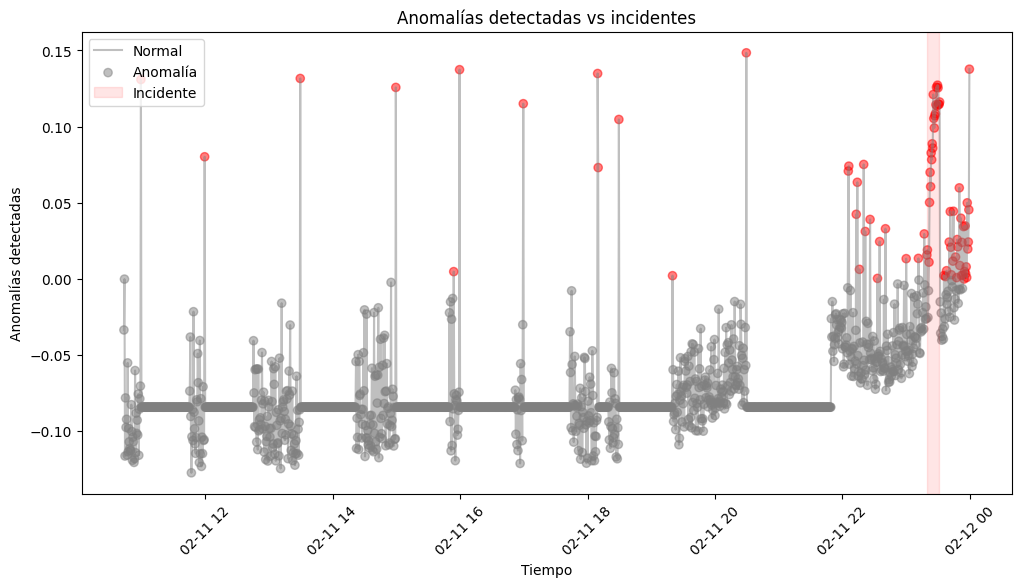

In [37]:
colors = {'normal': 'gray', 'anomaly': 'red', 'incident': 'red'}
plots_if.plot_static(colors=colors)

In [38]:
combined_logs.to_csv('data/PDTI_Feb_11_2025.csv')

In [39]:
colors = {'normal': 'blue', 'anomaly': 'red', 'incident': 'blue'}
#cambiar a normal, anomaly, incident
plots_if.plot_dynamic(colors=colors)

In [40]:
anomaly_indices = [i for i, x in enumerate(predictions) if x == -1]
anomaly_indices


[32,
 152,
 332,
 512,
 621,
 632,
 752,
 892,
 893,
 932,
 1033,
 1172,
 1364,
 1365,
 1379,
 1381,
 1385,
 1393,
 1396,
 1405,
 1419,
 1423,
 1434,
 1473,
 1496,
 1507,
 1512,
 1513,
 1516,
 1517,
 1518,
 1519,
 1520,
 1521,
 1522,
 1523,
 1524,
 1525,
 1526,
 1527,
 1528,
 1529,
 1530,
 1531,
 1532,
 1533,
 1534,
 1535,
 1536,
 1544,
 1547,
 1549,
 1554,
 1556,
 1557,
 1558,
 1561,
 1562,
 1566,
 1568,
 1569,
 1570,
 1573,
 1574,
 1576,
 1577,
 1578,
 1580,
 1581,
 1582,
 1583,
 1584,
 1585,
 1586,
 1587,
 1588,
 1589,
 1590,
 1591,
 1592]

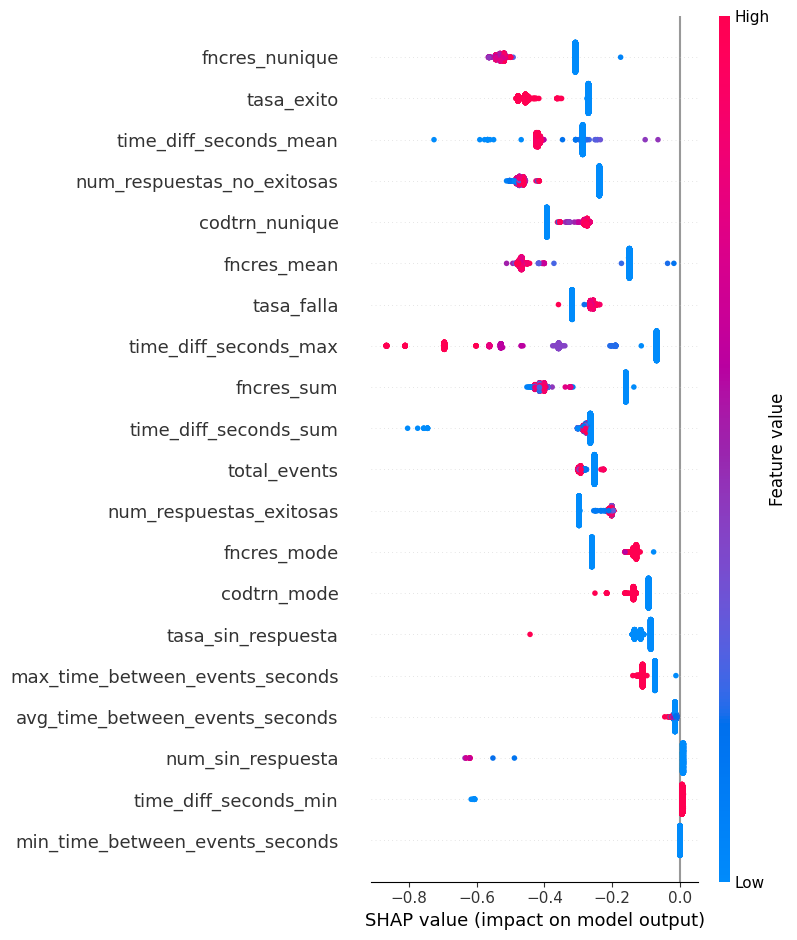

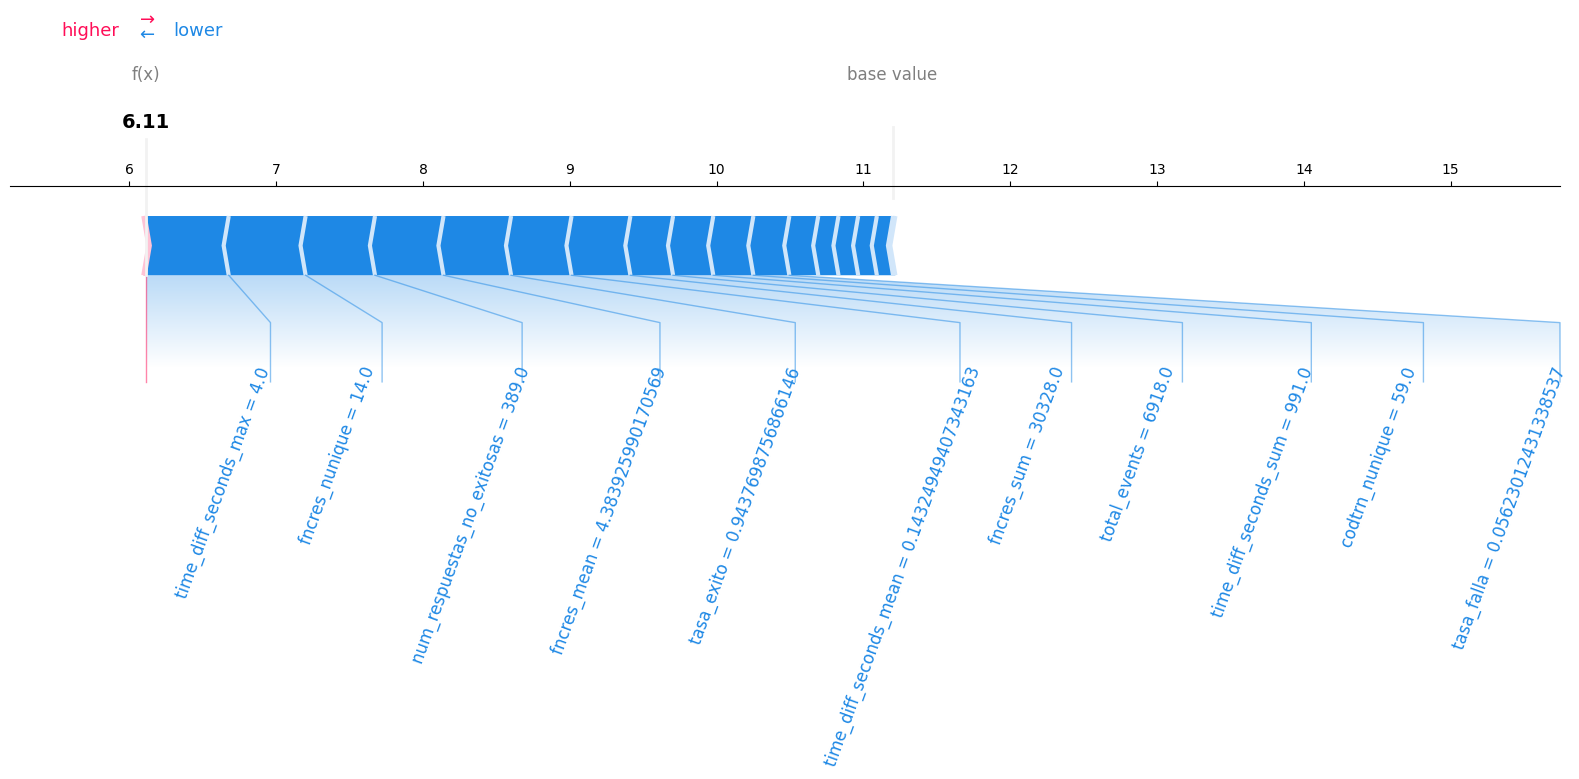

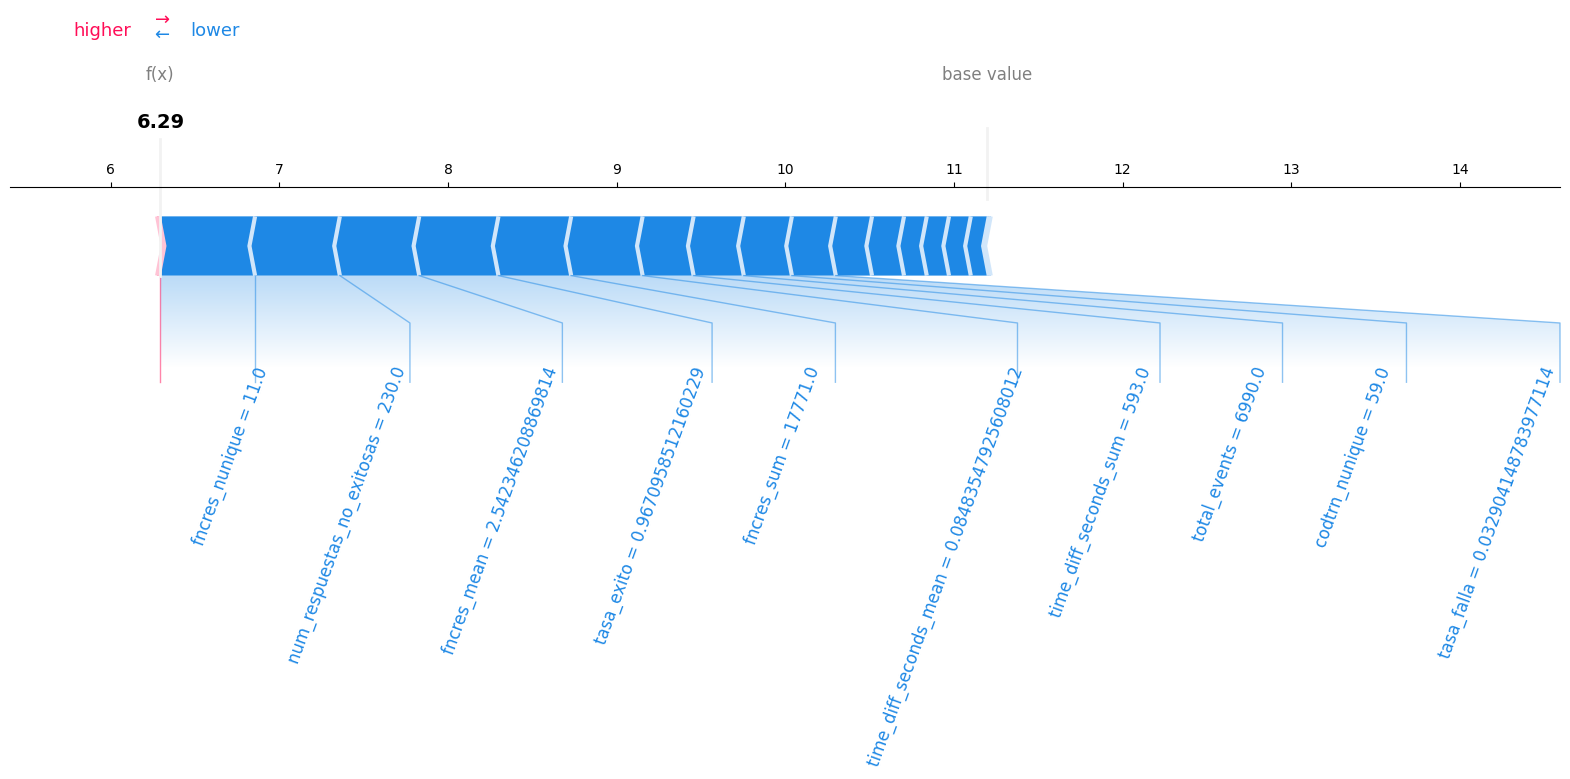

In [41]:
explainer = sentinel.visualization.SHAPVisualizer(if_detector)
explainer.plot_summary(X_train_raw)
explainer.plot_force(X_train_raw,1364)
explainer.plot_force(X_train_raw,1360)

In [42]:
#!pip install shap
import shap
# Crear un explainer SHAP
explainer = shap.TreeExplainer(if_detector)
shap_values = explainer.shap_values(X_train)

InvalidModelError: Model type not yet supported by TreeExplainer: <class 'sla.detectors.isolation_forest.IsolationForestDetector'>

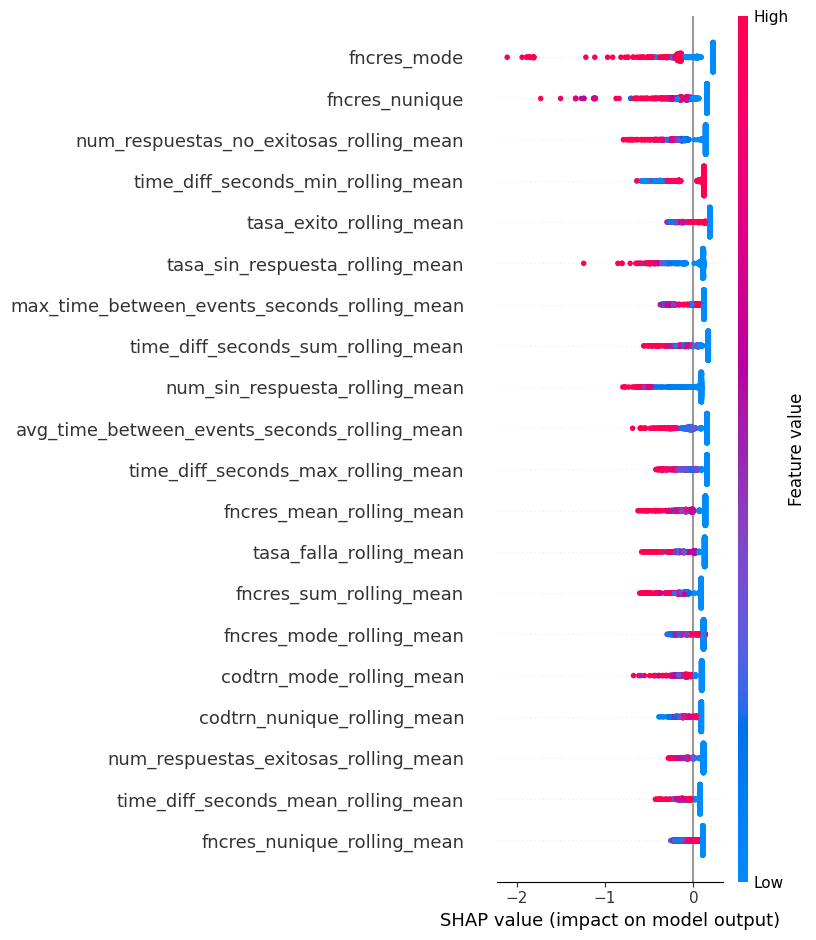

In [187]:
shap.summary_plot(shap_values, X_train_raw)


463


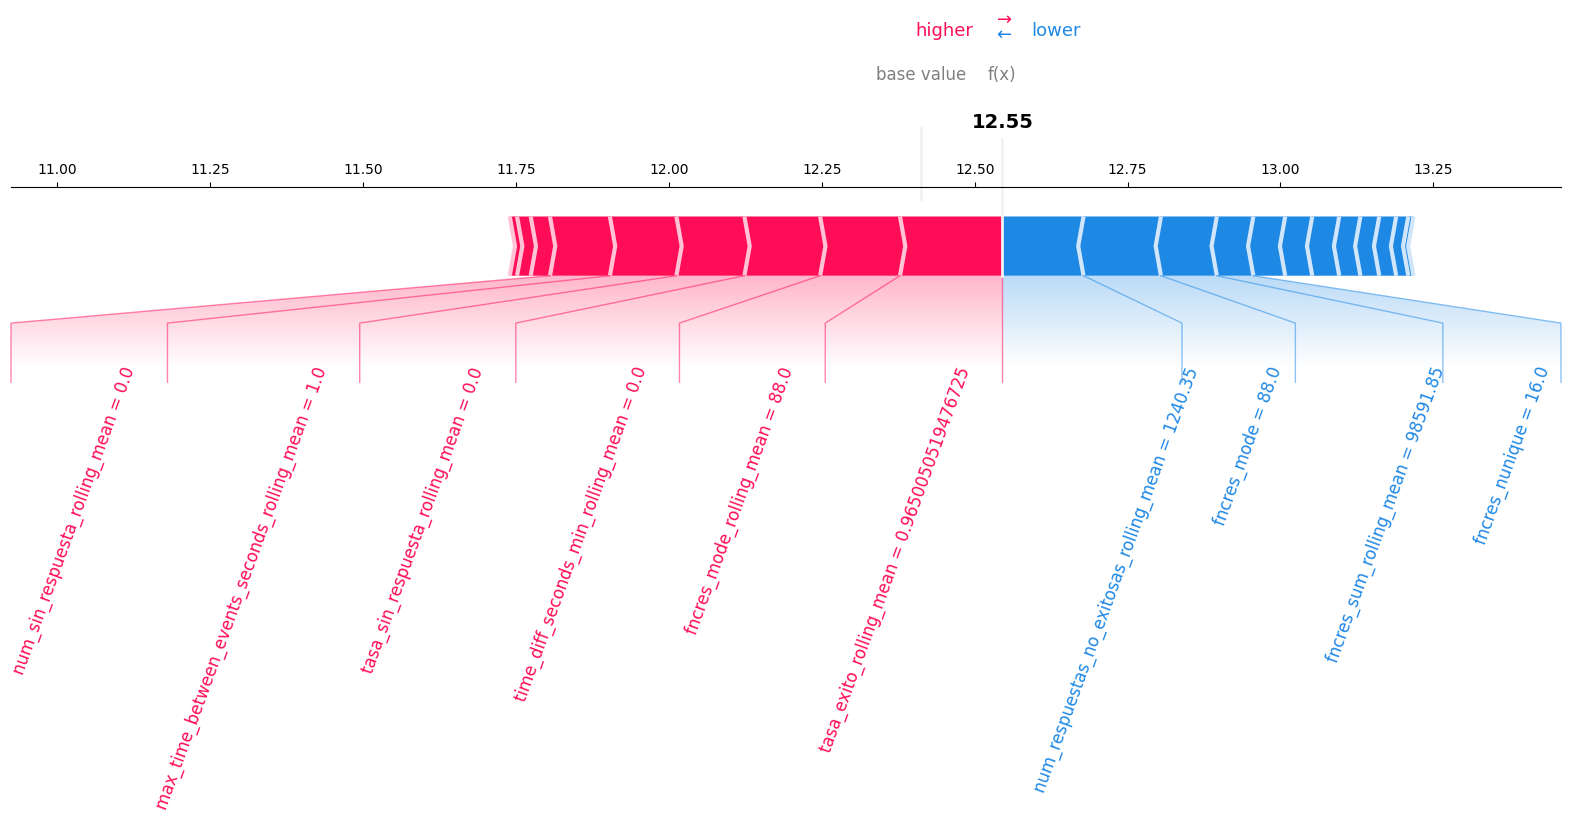

total_events_rolling_mean                       35408.500000
time_diff_seconds_mean_rolling_mean                 0.095565
time_diff_seconds_sum_rolling_mean               3385.750000
time_diff_seconds_min_rolling_mean                  0.000000
time_diff_seconds_max_rolling_mean                  4.150000
fncres_sum_rolling_mean                         98591.850000
fncres_mode_rolling_mean                           88.000000
fncres_nunique_rolling_mean                        17.300000
fncres_mean_rolling_mean                            2.782024
codtrn_mode_rolling_mean                          369.000000
codtrn_nunique_rolling_mean                        68.050000
num_respuestas_exitosas_rolling_mean            34168.150000
num_respuestas_no_exitosas_rolling_mean          1240.350000
num_sin_respuesta_rolling_mean                      0.000000
avg_time_between_events_seconds_rolling_mean        0.000821
min_time_between_events_seconds_rolling_mean        0.000000
max_time_between_events_

In [189]:
import shap
shap.initjs()

anomaly_index = 463
print(anomaly_index)
shap.force_plot(explainer.expected_value, shap_values[anomaly_index], X_train_raw.iloc[anomaly_index], matplotlib=True, link='identity', figsize=(20, 5),text_rotation=70)
rolling_mean_logs.iloc[anomaly_index]


583


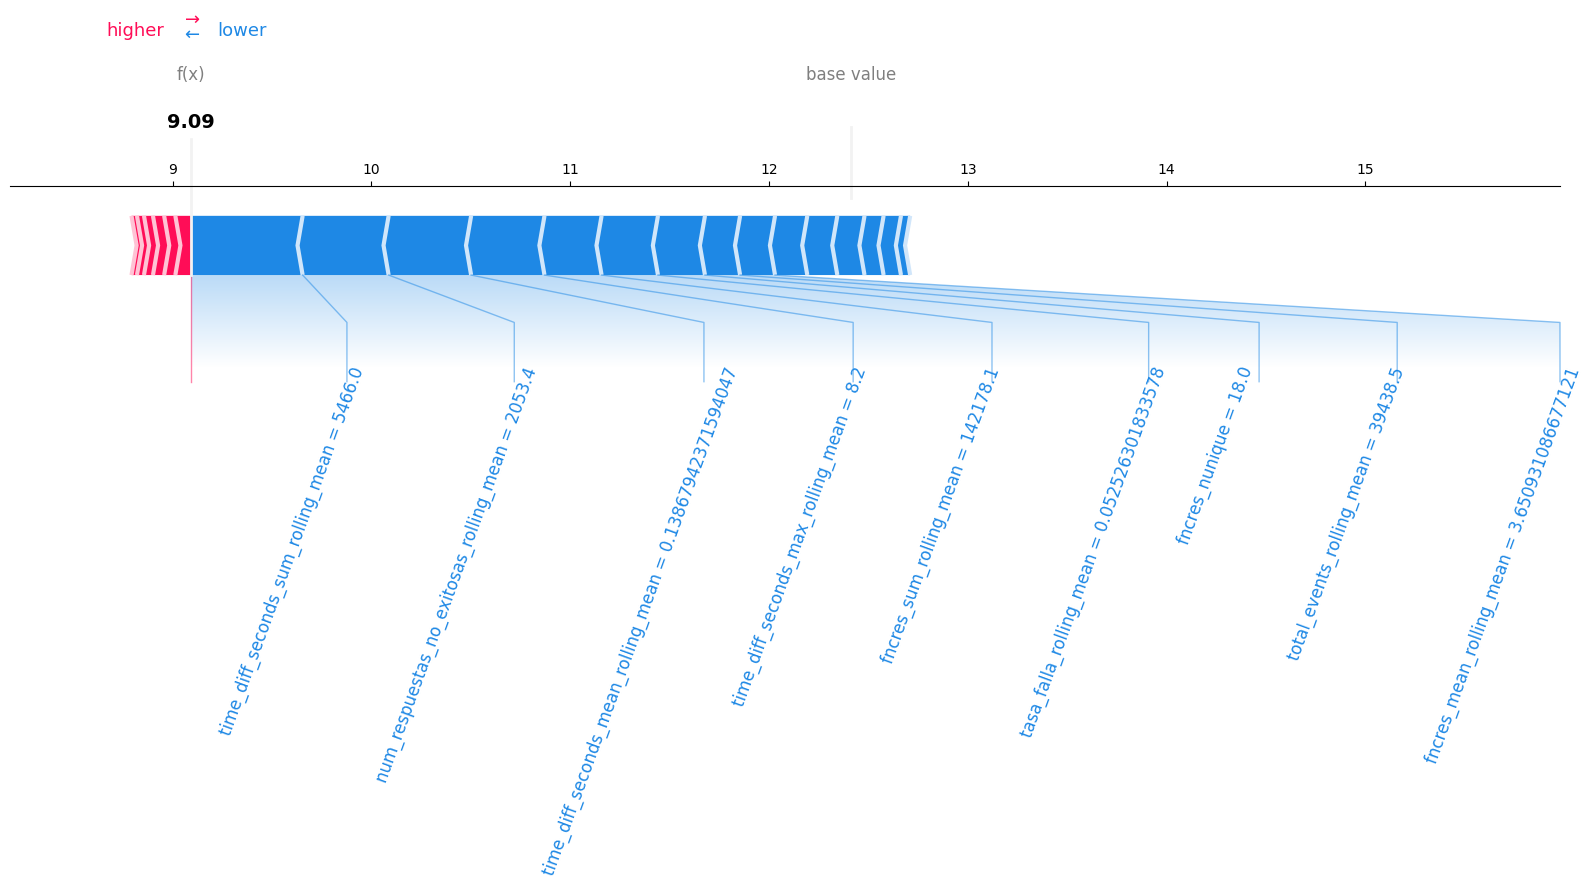

In [190]:
anomaly_index = 583
print(anomaly_index)
shap.force_plot(explainer.expected_value, shap_values[anomaly_index], X_train_raw.iloc[anomaly_index],  matplotlib=True, link='identity', figsize=(20, 5),text_rotation=70)

### RRCF

In [44]:
# Initialize the detector
rrcf_detector = sentinel.detectors.RRCFDetector(shingle_size=60)

# Get anomaly scores
anomaly_scores = rrcf_detector.fit_predict(combined_logs)

# Get anomalies with a threshold
anomalies = rrcf_detector.get_anomalies(threshold=np.percentile(anomaly_scores, 97))

# Print the results
print("Anomaly Scores:\n", anomaly_scores)
print("Anomalies:\n", anomalies)

Anomaly Scores:
 0         0.000000
1         0.000000
2         0.000000
3         0.000000
4         0.000000
           ...    
1588     72.295605
1589     26.974072
1590     42.300305
1591     34.995340
1592    128.165755
Length: 1593, dtype: float64
Anomalies:
 1172    131.964025
1364     43.186249
1365     31.482142
1383     31.485689
1488     38.112824
1489     27.260259
1491     76.459806
1492     27.737576
1494     44.253551
1496     51.930185
1498     24.482344
1501     35.537074
1504     79.266544
1510     24.147800
1513     23.871897
1514     35.960711
1515     57.236685
1517     24.811834
1518    116.397417
1519     66.388722
1520    126.936913
1521     67.169135
1522    135.446859
1523    100.447188
1524    129.835908
1525     57.095220
1526     47.099754
1527    122.434152
1528    133.381421
1529     51.093043
1530     28.870328
1531     34.927681
1532    106.129292
1533     28.826994
1534     30.016743
1535     27.628243
1536     26.932839
1539     25.029690
1542     28

In [45]:
df_rrcf = rolling_mean_logs.copy()
df_rrcf = combined_logs.copy()
df_rrcf['scores'] = anomaly_scores.values
anomalies_index = df_rrcf.iloc[anomalies.index].index

In [193]:
df_rrcf.head()

,total_events_rolling_mean,time_diff_seconds_mean_rolling_mean,time_diff_seconds_sum_rolling_mean,time_diff_seconds_min_rolling_mean,time_diff_seconds_max_rolling_mean,fncres_sum_rolling_mean,fncres_mode_rolling_mean,fncres_nunique_rolling_mean,fncres_mean_rolling_mean,codtrn_mode_rolling_mean,...,num_sin_respuesta_rolling_mean,avg_time_between_events_seconds_rolling_mean,min_time_between_events_seconds_rolling_mean,max_time_between_events_seconds_rolling_mean,tasa_exito_rolling_mean,tasa_falla_rolling_mean,tasa_sin_respuesta_rolling_mean,fncres_mode,fncres_nunique,scores
2025-01-21 07:07:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88.0,3.0,0.0
2025-01-21 07:07:30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88.0,11.0,0.0
2025-01-21 07:08:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88.0,12.0,0.0
2025-01-21 07:08:30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88.0,12.0,0.0
2025-01-21 07:09:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88.0,13.0,0.0


In [51]:

import plotly.graph_objects as go

# Crear la figura
fig = go.Figure()

# Añadir la línea de puntuaciones de anomalías
fig.add_trace(go.Scatter(x=df_rrcf.index, y=df_rrcf['scores'], mode='lines+markers', name='Anomaly Scores', line=dict(color='blue'), marker=dict(size=5, opacity=0.4)))

# Añadir los puntos de anomalías
fig.add_trace(go.Scatter(x=anomalies_index, y=df_rrcf.loc[anomalies_index, 'scores'], mode='markers', name='Anomalies', marker=dict(color='red', size=8)))

# Resaltar el incidente entre las 12 pm y la 1 pm
fig.add_vrect(x0='2025-02-11 23:59:59', x1='2025-02-12 00:11:00', fillcolor='orange', opacity=0.3, layer='below', line_width=0, annotation_text='Incidente: App personas, Mi Bancolombia', annotation_position='top left')
